# Vehicle Detection Project

In this project, the goal was to write a software pipeline to detect vehicles in a video starting with the "./test_videos/test_video.mp4", and then implement on full "./test_videos/project_video.mp4"

#### The goals are to:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles
- Estimate a bounding box for vehicles detected

## Histogram of Oriented Gradients (HOG) Functions

In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for i in imgs:
        # Read in each one by one
        image = mpimg.imread(i)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

## Explore Dataset

In [2]:
# Get car and non-vehicle images
car_images = glob.glob('test_images/vehicles/**/*.png')
noncar_images = glob.glob('test_images/non-vehicles/**/*.png')

# Print lengths
print("Car images:")
print(len(car_images))
print()
print("Non-vehicle images:")
print(len(noncar_images))

Car images:
8792

Non-vehicle images:
8968


## View Some Samples

Car and not-car sample images from the training set:


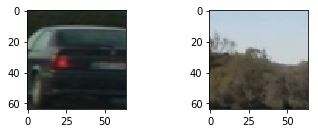

In [3]:
# Get sample images from training set
car_img    = mpimg.imread(car_images[0])
not_car_img = mpimg.imread(noncar_images[0])

# Plot sample images from training set
print("Car and not-car sample images from the training set:")
fig = plt.figure()
fig.add_subplot(2,2,1)
plt.imshow(car_img.squeeze(), cmap="gray")
fig.add_subplot(2,2,2)
plt.imshow(not_car_img.squeeze(), cmap="gray")

## Get Histogram of Oriented Gradients (HOG) For Samples Images

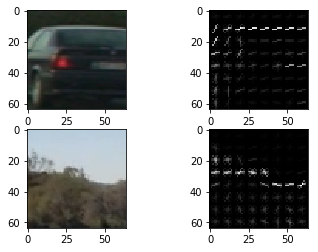

In [4]:
# Get Sample Images
car_img = mpimg.imread(car_images[0])
not_car_img = mpimg.imread(noncar_images[0])

# Get HOG features from images
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
_, not_car_dst = get_hog_features(not_car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Display images next to their hog features 
fig = plt.figure()
fig.add_subplot(2,2,1)
plt.imshow(car_img.squeeze(), cmap="gray")
fig.add_subplot(2,2,2)
plt.imshow(car_dst.squeeze(), cmap="gray")
fig.add_subplot(2,2,3)
plt.imshow(not_car_img.squeeze(), cmap="gray")
fig.add_subplot(2,2,4)
plt.imshow(not_car_dst.squeeze(), cmap="gray")

## Extract Features From HOG Images

In [5]:
# Feature extraction parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

# Get features for images with cars
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

# Get features for images without cars
notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Print feature details
print()
print('Using',orient,'orientations with',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


Using 11 orientations with 16 pixels per cell and 2 cells per block
Feature vector length: 1188


## Train a Linear SVC to recognize images of cars and images without cars

In [6]:
# Create a linear SVC 
svc = LinearSVC()

# Train the SVC Classifer using the .fit() method
svc.fit(X_train, y_train)

# Check the accuracy of the SVC
print('Test Accuracy =', round(svc.score(X_test, y_test), 4))

Test Accuracy = 0.9803


## Finding cars in images and drawing rectangles around them

In [7]:
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # Define array of rectangles surrounding cars that were detected
    rectangles = []
    
    # Normalize image
    img = img.astype(np.float32)/255
    search_img = img[ystart:ystop,:,:]

    # Apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            search_ctrans = cv2.cvtColor(search_img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            search_ctrans = cv2.cvtColor(search_img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            search_ctrans = cv2.cvtColor(search_img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            search_ctrans = cv2.cvtColor(search_img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            search_ctrans = cv2.cvtColor(search_img, cv2.COLOR_RGB2YCrCb)
    else: search_ctrans = np.copy(image)   
    
    # Rescale image if not 1.0
    if scale != 1:
        img_shape = search_ctrans.shape
        search_ctrans = cv2.resize(search_ctrans, (np.int(img_shape[1]/scale), np.int(img_shape[0]/scale)))
    
    # Select color channel for HOG 
    if hog_channel == 'ALL':
        channel_1 = search_ctrans[:,:,0]
        channel_2 = search_ctrans[:,:,1]
        channel_3 = search_ctrans[:,:,2]
    else: 
        channel_1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks
    nx_blocks = (channel_1.shape[1] // pix_per_cell)+1  #-1
    ny_blocks = (channel_1.shape[0] // pix_per_cell)+1  #-1 
    
    # Define sampling rate with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2
    nx_steps = (nx_blocks - nblocks_per_window) // cells_per_step
    ny_steps = (ny_blocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(channel_1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(channel_2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(channel_3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for x in range(nx_steps):
        for y in range(ny_steps):
            y_position = y * cells_per_step
            x_position = x * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[y_position:y_position+nblocks_per_window, x_position:x_position+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[y_position:y_position+nblocks_per_window, x_position:x_position+nblocks_per_window].ravel() 
                hog_feat3 = hog3[y_position:y_position+nblocks_per_window, x_position:x_position+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            x_left = x_position*pix_per_cell
            y_top = y_position*pix_per_cell
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                x_box_left = np.int(x_left*scale)
                y_top_draw = np.int(y_top*scale)
                window_draw = np.int(window*scale)
                rectangles.append(((x_box_left, y_top_draw+ystart),(x_box_left+window_draw,y_top_draw+window_draw+ystart)))
                
    return rectangles

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

## Find Potenial Cars In Test Image

In [8]:
# Get test image
test_img = mpimg.imread('./test_images/test4.jpg')

# Set parameters for find_cars function
ystart = 400
ystop = 660
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

# Get output rectangles surrounding the cars we found
rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, 
                       hog_channel, svc, None, orient, pix_per_cell,
                       cell_per_block, None, None)

# Print home many rectangles we found in the image
print(len(rectangles), 'potential cars found in image')

6 potential cars found in image


## Test drawing on image

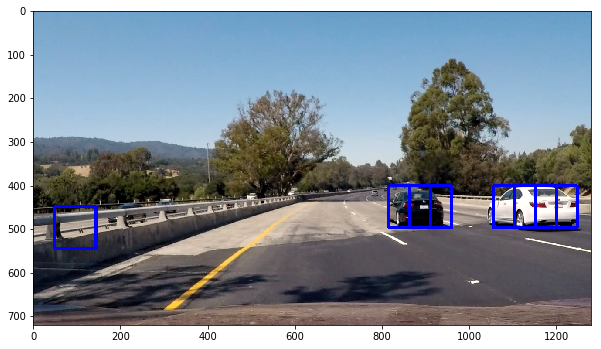

In [9]:
# Draw boxes where cars are located in test image
test_img_rects = draw_boxes(test_img, rectangles)

# Plot the new image
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

## Exploring Layers of Rectangles

Number of potential cars:  39


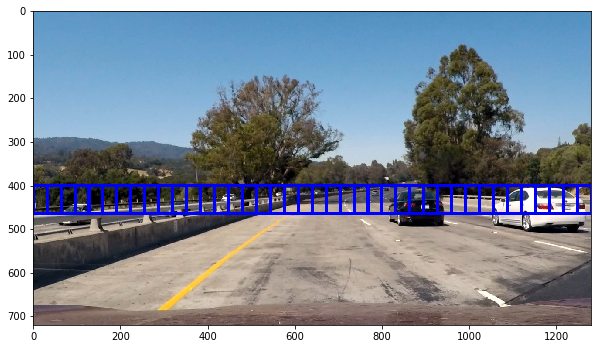

In [10]:
# Load test image
test_img = mpimg.imread('./test_images/test1.jpg')

# Create array to hold the select boxes where we found cars
rects = []

# Set search dimensions for layer
ystart = 400
ystop = 470
scale = 1.0

# Find rectanlges in image and add them to the list
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

# Set search dimensions for layer
ystart = 420
ystop = 480
scale = 1.0

# Find rectangles in image and add them to the list
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

# Flatten the list of lists
rectangles = [item for sublist in rects for item in sublist]
test_img_rects = draw_boxes(test_img, rectangles)

# Plot the rectangles on the image
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of potential cars: ', len(rectangles))

Number of potential cars:  50


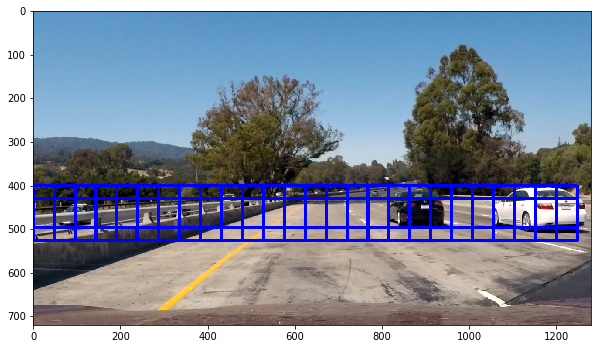

In [11]:
# Load test image
test_img = mpimg.imread('./test_images/test1.jpg')

# Create array to hold the select boxes where we found cars
rects = []

# Set search dimensions for layer
ystart = 400
ystop = 500
scale = 1.5

# Find rectangles in image and add them to the list
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

# Set search dimensions for layer
ystart = 430
ystop = 530
scale = 1.5

# Find rectangles in image and add them to the list
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

# Flatten the list of lists
rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles)

# Plot the rectangles on the image
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of potential cars: ', len(rectangles))

Number of potential cars:  38


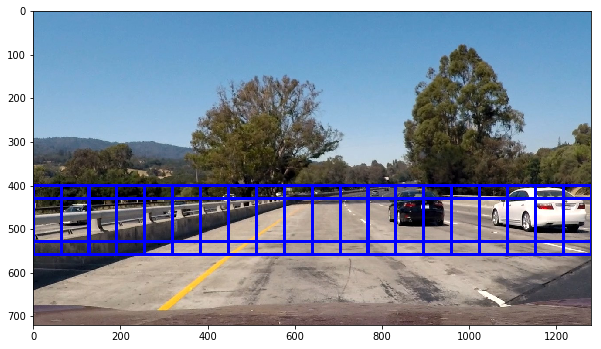

In [12]:
# Load test image
test_img = mpimg.imread('./test_images/test1.jpg')

# Create array to hold the select boxes where we found cars
rects = []

# Set search dimensions for layer
ystart = 400
ystop = 530
scale = 2.0

# Find rectangles in image and add them to the list
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

# Set search dimensions for layer
ystart = 430
ystop = 560
scale = 2.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

# Flatten the list of lists
rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles)

# Plot the rectangles on the image
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of potential cars: ', len(rectangles))

Number of potential cars:  24


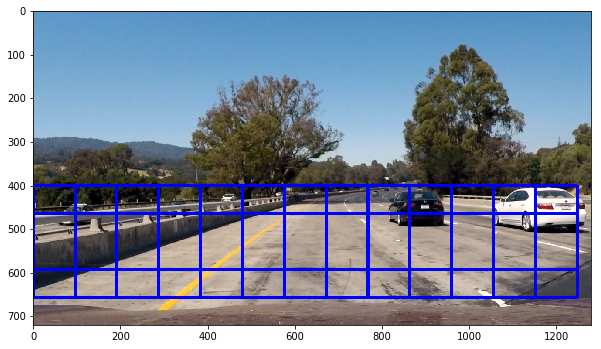

In [13]:
# Load test image
test_img = mpimg.imread('./test_images/test1.jpg')

# Create array to hold the select boxes where we found cars
rects = []

# Set search dimensions for layer
ystart = 400
ystop = 600
scale = 3.0

# Find rectangles in image and add them to the list
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

# Set search dimensions for layer
ystart = 464
ystop = 660
scale = 3.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

# Flatten the list of lists
rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles)

# Plot the rectangles on the image
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of potential cars: ', len(rectangles))

## Drawing Blocks Around Cars

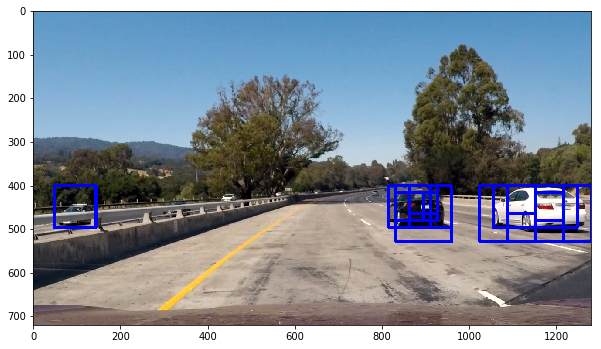

In [14]:
# Load test image
test_img = mpimg.imread('./test_images/test1.jpg')

# Create array to hold the select boxes where we found cars
rectangles = []

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

# Set search dimensions for layer
ystart = 400
ystop = 464
scale = 1.0

# Find rectangles in image and add them to the list
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# Set search dimensions for layer
ystart = 416
ystop = 480
scale = 1.0

# Find rectangles in image and add them to the list
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# Set search dimensions for layer
ystart = 400
ystop = 496
scale = 1.5

# Find rectangles in image and add them to the list
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# Set search dimensions for layer
ystart = 432
ystop = 528
scale = 1.5

# Find rectangles in image and add them to the list
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# Set search dimensions for layer
ystart = 400
ystop = 528
scale = 2.0

# Find rectangles in image and add them to the list
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# Set search dimensions for layer
ystart = 432
ystop = 560
scale = 2.0

# Find rectangles in image and add them to the list
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# Set search dimensions for layer
ystart = 400
ystop = 596
scale = 3.5

# Find rectangles in image and add them to the list
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# Set search dimensions for layer
ystart = 464
ystop = 660
scale = 3.5

# Find rectangles in image and add them to the list
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# Flatten the list of lists
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles)

# Plot the rectangles on the image
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

## View Cars Through Heatmap

### Heatmap Functions

In [15]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

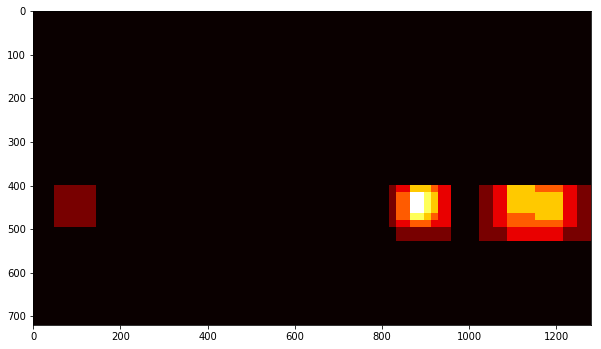

In [16]:
# Test heatmap on test image
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)

# Plot result
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

## Thresholding The Heatmap

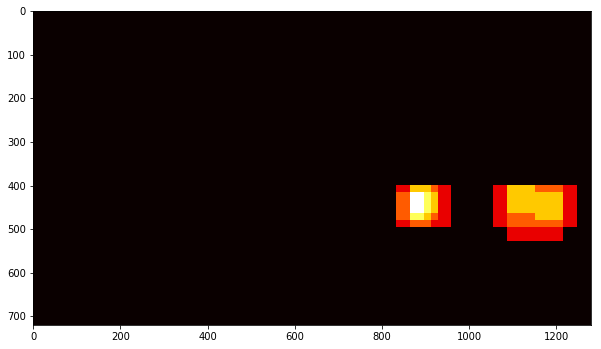

In [17]:
# Threshold the heat map so it only shows places with lots of heat
heatmap_img = apply_threshold(heatmap_img, 1)

# Plot the updated heatmap
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

# Get labels from heatmap image
labels = label(heatmap_img)

## Test Final Drawing Function

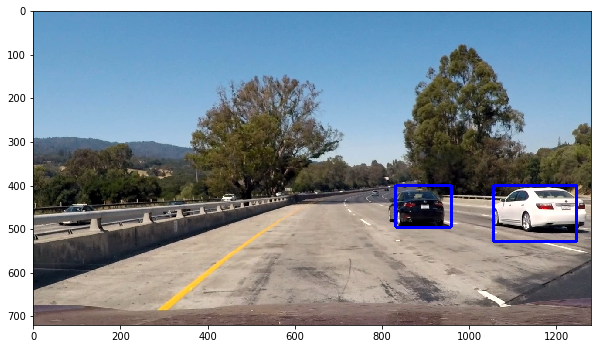

In [18]:
# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

## Define Processing Pipeline for Images & Videos

In [19]:
def process_frame(img):

    # Create array to hold the select boxes where we found cars
    rectangles = []

    # Set parameters for find_cars() function
    colorspace = 'YUV'
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL'

    # Set dimentions for rectangle layer
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    # Set dimentions for rectangle layer
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    # Set dimentions for rectangle layer
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    # Set dimentions for rectangle layer
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    # Set dimentions for rectangle layer
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    # Set dimentions for rectangle layer
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    # Set dimentions for rectangle layer
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    # Set dimentions for rectangle layer
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    # Flatten list of lists
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # Get heatmap image and apply threshold to frame
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    
    # Get labels from heatmap output
    labels = label(heatmap_img)
    
    # Draw boxes on image based on above calculations
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

def process_frame_for_video(img):

    # Create array to hold the select boxes where we found cars
    rectangles = []

    # Set parameters for find_cars() function
    colorspace = 'YUV'
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL'
    
    # Set dimentions for rectangle layer
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    # Set dimentions for rectangle layer
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    # Set dimentions for rectangle layer
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    # Set dimentions for rectangle layer
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    # Set dimentions for rectangle layer
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    # Set dimentions for rectangle layer
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    # Set dimentions for rectangle layer
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    # Set dimentions for rectangle layer
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
 
    # Flatten list of lists
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # Add detections to the history
    if len(rectangles) > 0:
        rm.add_rects(rectangles)
    
    # Get heatmap image for every frame
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in rm.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(rm.prev_rects)//2)
    
    # Get labels from heatmap output
    labels = label(heatmap_img)
    
    # Draw rectangles on image and output
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

# Create a class to keep track of the previous frame's rectangles
class Rectangle_Memory():
    
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

rm = Rectangle_Memory()

## Try Pipeline On Test Images

Test image output:


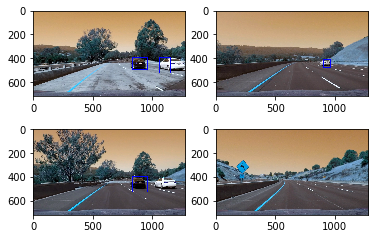

In [20]:
# Load test images
test_images = glob.glob('./test_images/test*.jpg')

# Process test images
img1 = process_frame(cv2.imread(test_images[1]))
img2 = process_frame(cv2.imread(test_images[2]))
img3 = process_frame(cv2.imread(test_images[3]))
img4 = process_frame(cv2.imread(test_images[4]))

# Plot test images
fig = plt.figure()
print("Test image output:")
fig.add_subplot(2,2,1)
plt.imshow(img1.squeeze(), cmap="gray")
fig.add_subplot(2,2,2)
plt.imshow(img2.squeeze(), cmap="gray")
fig.add_subplot(2,2,3)
plt.imshow(img3.squeeze(), cmap="gray")
fig.add_subplot(2,2,4)
plt.imshow(img4.squeeze(), cmap="gray")

## Test Pipeline On Videos

In [21]:
# Load Test Video
test_video_result = 'output_files/test_video_result.mp4'

# Write out test_result_video
clip_test = VideoFileClip('test_videos/test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_video_result, audio=False)

[MoviePy] >>>> Building video output_files/test_video_result.mp4
[MoviePy] Writing video output_files/test_video_result.mp4


 97%|█████████▋| 38/39 [00:08<00:00,  3.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_files/test_video_result.mp4 

CPU times: user 19.5 s, sys: 68 ms, total: 19.5 s
Wall time: 10.2 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_video_result))

In [23]:
# Load Project Video
project_video_result = 'output_files/project_video_result.mp4'

# Write Out Project Video
project_video = VideoFileClip('test_videos/project_video.mp4')
project_video_out = project_video.fl_image(process_frame_for_video)
%time project_video_out.write_videofile(project_video_result, audio=False)

[MoviePy] >>>> Building video output_files/project_video_result.mp4
[MoviePy] Writing video output_files/project_video_result.mp4


100%|█████████▉| 1260/1261 [05:06<00:00,  3.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_files/project_video_result.mp4 

CPU times: user 10min 58s, sys: 2.2 s, total: 11min 1s
Wall time: 5min 6s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_result))